<a href="https://colab.research.google.com/github/kanri3/deep_learning_day3_day4/blob/main/pytorch_hands_on_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第3回　PyTorchによるディープラーニング実装手順の基本

## ■（5）データセットとデーターローダー（DataLoader）

「[第1回　初めてのニューラルネットワーク実装、まずは準備をしよう ― 仕組み理解×初実装（前編）：TensorFlow 2＋Keras（tf.keras）入門 - ＠IT](https://www.atmarkit.co.jp/ait/articles/1909/19/news026.html)」の記事と同じように、シンプルな座標点データを生成して使う。使い方は、前述の記事を参照してほしい。

なお、座標点データは、「[ニューラルネットワーク Playground - Deep Insider](https://deepinsider.github.io/playground/)」（以下、Playground）と同じ生成仕様となっている。

### リスト5-1　座標点データの生成

In [1]:
# 座標点データを生成するライブラリのインストール
!pip install playground-data

  Created wheel for playground-data: filename=playground_data-1.1.1-py2.py3-none-any.whl size=20798 sha256=f250dd21a70b6a4854dc36298f83a6dec1a0ef153a14126091203b0f187c6174
  Stored in directory: /root/.cache/pip/wheels/0a/83/26/9701478cd2f31df42fcc7d2cf0fa3fd6ff23cf8e44346166f3
Successfully built playground-data


In [2]:
# playground-dataライブラリのplygdataパッケージを「pg」という別名でインポート
import plygdata as pg

# 設定値を定数として定義
PROBLEM_DATA_TYPE = pg.DatasetType.ClassifyCircleData # 問題種別：「分類（Classification）」、データ種別：「円（CircleData）」を選択
TRAINING_DATA_RATIO = 0.5  # データの何％を訓練【Training】用に？ (残りは精度検証【Validation】用) ： 50％
DATA_NOISE = 0.0           # ノイズ： 0％

# 定義済みの定数を引数に指定して、データを生成する
data_list = pg.generate_data(PROBLEM_DATA_TYPE, DATA_NOISE)

# データを「訓練用」と「精度検証用」を指定の比率で分割し、さらにそれぞれを「データ（X）」と「教師ラベル（y）」に分ける
X_train, y_train, X_valid, y_valid = pg.split_data(data_list, training_size=TRAINING_DATA_RATIO)

# データ分割後の各変数の内容例として、それぞれ5件ずつ出力
print('X_train:'); print(X_train[:5])
print('y_train:'); print(y_train[:5])
print('X_valid:'); print(X_valid[:5])
print('y_valid:'); print(y_valid[:5])

X_train:
[[-0.74603377 -0.83009882]
 [ 3.74373198 -0.43348149]
 [ 4.42617578  1.36991257]
 [-3.86253484 -0.64020839]
 [ 0.37063188  0.04299322]]
y_train:
[[ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]]
X_valid:
[[ 2.60863208e-01 -1.56930102e+00]
 [ 1.31089532e-02 -3.94723588e+00]
 [-3.24950024e-03 -2.54868653e-01]
 [-1.27034655e+00 -3.87277236e+00]
 [ 2.06355786e-01  4.69248472e-01]]
y_valid:
[[ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]


### リスト5-2　データセットとデーターローダーの作成

PyTorchにはミニバッチを簡単に扱うための`DataLoader`クラスが用意されている。このクラスを利用するには、既存のデータや教師ラベルといったテンソルを1つの`TensorDataset`にまとめる必要がある。

In [3]:
# データ関連のユーティリティクラスをインポート
from torch.utils.data import TensorDataset, DataLoader
import torch       # ライブラリ「PyTorch」のtorchパッケージをインポート

# 定数（学習方法設計時に必要となるもの）
BATCH_SIZE = 15  # バッチサイズ： 15（Playgroundの選択肢は「1」～「30」）

# NumPy多次元配列からテンソルに変換し、データ型は`float`に変換する
t_X_train = torch.from_numpy(X_train).float()
t_y_train = torch.from_numpy(y_train).float()
t_X_valid = torch.from_numpy(X_valid).float()
t_y_valid = torch.from_numpy(y_valid).float()

# 「データ（X）」と「教師ラベル（y）」を、1つの「データセット（dataset）」にまとめる
dataset_train = TensorDataset(t_X_train, t_y_train)  # 訓練用
dataset_valid = TensorDataset(t_X_valid, t_y_valid)  # 精度検証用

# ミニバッチを扱うための「データローダー（loader）」（訓練用と精度検証用）を作成
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE)

このコードのポイント：
- バッチサイズは学習時に扱うデータ単位であるが、`DataLoader`が「ミニバッチ」に関係するため、この段階で定義しておく必要がある
- `DataLoader`クラスのコンストラクター引数`shuffle`で、データをシャッフルするか（**True**）しないか（**False**）を指定できる。今回はシャッフルしている

## ■（6）ディープニューラルネットのモデル定義

### リスト6-1　「1」か「-1」に分類するための「出力の離散化」
- 今回のニューラルネットワークでは出力された確率値を、「**1**」か「**-1**」の2クラス分類値に離散化する
  - 具体的には、0.0未満／0.0以上を-1.0／1.0にスケール変換する
- そのための独自関数`discretize`を定義する
- さらに、モデル内で扱いやすいように`torch.nn.Module`化も行っておく（※本稿では使用しない）
- `discretize`関数は後述の「リスト7-3　1回分の「訓練（学習）」と「評価」の処理」で使用する

In [4]:
import torch       # ライブラリ「PyTorch」のtorchパッケージをインポート
import torch.nn as nn  # 「ニューラルネットワーク」モジュールの別名定義

# 離散化を行う単なる関数
def discretize(proba):
    '''
    実数の確率値を「1」か「-1」の2クラス分類値に離散化する。
    閾値は「0.0以上」か「未満」か。データ型は「torch.float」を想定。
  
    Examples:
        >>> proba = torch.tensor([-0.5, 0.0, 0.5], dtype=torch.float)
        >>> binary = discretize(proba)
    '''
    threshold = torch.Tensor([0.0]) # -1か1かを分ける閾値を作成
    discretized = (proba >= threshold).float() # 閾値未満で0、以上で1に変換
    return discretized * 2 - 1.0 # 2倍して-1.0することで、0／1を-1.0／1.0にスケール変換

# discretize関数をモデルで簡単に使用できるようにするため、
# PyTorchの「torch.nn.Module」を継承したクラスラッパーも作成した
class Discretize(nn.Module):
    '''
    実数の確率値を「1」か「-1」の2クラス分類値に離散化する。
    閾値は「0.0以上」か「未満」か。データ型は「torch.float」を想定。
  
    Examples:
        >>> d = Discretize()
        >>> proba = torch.tensor([-0.5, 0.0, 0.5], dtype=torch.float)
        >>> binary = d(proba)
    '''        
    def __init__(self):
        super().__init__()

    # forward()メソッドは、基本クラス「torch.nn.Module」の__call__メソッドからも呼び出されるため、
    # Discretizeオブジェクトを関数のように使える（例えば上記の「d(proba)」）
    def forward(self, proba):
        return discretize(proba) # 上記の関数を呼び出すだけ

# 関数の利用をテスト
proba = torch.tensor([-0.5, 0.0, 0.5], dtype=torch.float)  # 確率値の例
binary = discretize(proba)  # 2クラス分類（binary classification）値に離散化
binary  # tensor([-1.,  1.,  1.]) …… などと表示される

tensor([-1.,  1.,  1.])

このコードのポイント：
- PyTrochのニューラルネットワークの基本を解説する内容ではないので、ざっと流して読めば十分（コメントを参考にしてほしい）

### リスト6-2　ディープニューラルネットワークのモデル設計
- 入力の数（`INPUT_FEATURES`）は、$X_1$と$X_2$で**2つ**
- 隠れ層のレイヤー数は、**2つ**
  - 隠れ層にある1つ目のニューロンの数（`LAYER1_NEURONS`）は、**3つ**
  - 隠れ層にある2つ目のニューロンの数（`LAYER2_NEURONS`）は、**3つ**
- 出力層にあるニューロンの数（`OUTPUT_RESULTS`）は、**1つ**

In [5]:
import torch       # ライブラリ「PyTorch」のtorchパッケージをインポート
import torch.nn as nn  # 「ニューラルネットワーク」モジュールの別名定義

# 定数（モデル定義時に必要となるもの）
INPUT_FEATURES = 2      # 入力（特徴）の数： 2
LAYER1_NEURONS = 3      # ニューロンの数： 3
LAYER2_NEURONS = 3      # ニューロンの数： 3
OUTPUT_RESULTS = 1      # 出力結果の数： 1

# 変数（モデル定義時に必要となるもの）
activation1 = torch.nn.Tanh()  # 活性化関数（隠れ層用）： tanh関数（変更可能）
activation2 = torch.nn.Tanh()  # 活性化関数（隠れ層用）： tanh関数（変更可能）
acti_out = torch.nn.Tanh()     # 活性化関数（出力層用）： tanh関数（固定）

# torch.nn.Moduleによるモデルの定義
class NeuralNetwork(nn.Module):

    # レイヤー（層）を定義
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # 隠れ層：1つ目のレイヤー（layer）
        self.layer1 = nn.Linear(
            INPUT_FEATURES,                # 入力ユニット数（＝入力層）
            LAYER1_NEURONS)                # 次のレイヤーへの出力ユニット数

        # 隠れ層：2つ目のレイヤー（layer）
        self.layer2 = nn.Linear(
            LAYER1_NEURONS,                # 入力ユニット数
            LAYER2_NEURONS)                # 次のレイヤーへの出力ユニット数

        # 出力層
        self.layer_out = nn.Linear(
            LAYER2_NEURONS,                # 入力ユニット数
            OUTPUT_RESULTS)                # 出力結果への出力ユニット数

    # フォワードパスを定義
    def forward(self, x):
        # 「出力＝活性化関数（第n層（入力））」の形式で記述
        x = activation1(self.layer1(x))  # 活性化関数は変数として定義
        x = activation2(self.layer2(x))  # 同上
        x = acti_out(self.layer_out(x))  # ※活性化関数は「tanh」固定
        return x

# モデル（NeuralNetworkクラス）のインスタンス化
model = NeuralNetwork()
model   # モデルの内容を出力

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=3, bias=True)
  (layer2): Linear(in_features=3, out_features=3, bias=True)
  (layer_out): Linear(in_features=3, out_features=1, bias=True)
)

このコードのポイント：
- 基本的な内容は、前掲の「リスト1-1　ニューロンのモデル設計」と同じ
- 層が1つから、「隠れ層：2＋出力層：1」の3つに拡張されている
- 例えば「LAYER1_NEURONS」に着目すると、1つ目のレイヤーにおける「出力ユニット数」であり、2つ目のレイヤーの「入力ユニット数」でもあるので、全く同じものが指定されている
- フォワードプロパゲーション時のデータが変換されていく流れは、`forward`メソッド内に分かりやすく定義されている

## ■（7）学習／最適化（オプティマイザー）

### リスト7-1　オプティマイザー（最適化用オブジェクト）の作成

In [6]:
import torch.optim as optim   # 「最適化」モジュールの別名定義

# 定数（学習方法設計時に必要となるもの）
LEARNING_RATE = 0.03   # 学習率： 0.03
REGULARIZATION = 0.03  # 正則化率： 0.03

# オプティマイザーを作成（パラメーターと学習率も指定）
optimizer = optim.SGD(           # 最適化アルゴリズムに「SGD」を選択
    model.parameters(),          # 最適化で更新対象のパラメーター（重みやバイアス）
    lr=LEARNING_RATE,            # 更新時の学習率
    weight_decay=REGULARIZATION) # L2正則化（※不要な場合は0か省略）

このコードのポイント：
- この例では「SGD」（Stochastic Gradient Descent： 確率的勾配降下法）を選択
- パラメーター（重みやバイアス）と、学習率、正則化率を引数に指定
- 正則化（regularization）は「L2」に相当する。あまり使わない「L1」は基本機能に含まれていない
- `torch.optim.SGD`を含めて以下が使用可能
  - Adadelta
  - Adagrad
  - Adam（有名）
  - AdamW
  - SparseAdam
  - Adamax
  - ASGD
  - LBFGS
  - RMSprop
  - Rprop
  - SGD（確率的勾配降下法）

### リスト7-2　損失関数の定義
定義した損失関数は次のリスト7-3で利用する。

In [7]:
# 変数（学習方法設計時に必要となるもの）
criterion = nn.MSELoss()  # 損失関数：平均二乗誤差

このコードのポイント：
- `criterion`は慣例の変数名。誤差からの損失を測る「基準（criterion）」を意味する
- `nn.MSELoss`も含めて以外が使用可能
  - L1Loss（MAE：Mean Absolute Error、平均絶対誤差）
  - MSELoss（MSE：Mean Squared Error、平均二乗誤差）
  - CrossEntropyLoss（交差エントロピー誤差： クラス分類）
  - CTCLoss
  - NLLLoss
  - PoissonNLLLoss
  - KLDivLoss
  - BCELoss
  - BCEWithLogitsLoss
  - MarginRankingLoss
  - HingeEmbeddingLoss
  - MultiLabelMarginLoss
  - SmoothL1Loss
  - SoftMarginLoss
  - MultiLabelSoftMarginLoss
  - CosineEmbeddingLoss
  - MultiMarginLoss
  - TripletMarginLoss


### リスト7-3　1回分の「訓練（学習）」と「評価」の処理
`train_step`関数に訓練の内容を、`valid_step`関数に評価の内容を記述する。

In [8]:
def train_step(train_X, train_y):
    # 訓練モードに設定
    model.train()

    # フォワードプロパゲーションで出力結果を取得
    #train_X                # 入力データ
    pred_y = model(train_X) # 出力結果
    #train_y                # 正解ラベル

    # 出力結果と正解ラベルから損失を計算し、勾配を求める
    optimizer.zero_grad()   # 勾配を0で初期化（※累積してしまうため要注意）
    loss = criterion(pred_y, train_y)     # 誤差（出力結果と正解ラベルの差）から損失を取得
    loss.backward()   # 逆伝播の処理として勾配を計算（自動微分）

    # 勾配を使ってパラメーター（重みとバイアス）を更新
    optimizer.step()  # 指定されたデータ分の最適化を実施

    # 正解率を算出
    with torch.no_grad(): # 勾配は計算しないモードにする
        discr_y = discretize(pred_y)         # 確率値から「-1」／「1」に変換
        acc = (discr_y == train_y).sum()     # 正解数を計算する

    # 損失と正解数をタプルで返す
    return (loss.item(), acc.item())  # ※item()=Pythonの数値

def valid_step(valid_X, valid_y):
    # 評価モードに設定（※dropoutなどの挙動が評価用になる）
    model.eval()
    
    # フォワードプロパゲーションで出力結果を取得
    #valid_X                # 入力データ
    pred_y = model(valid_X) # 出力結果
    #valid_y                # 正解ラベル

    # 出力結果と正解ラベルから損失を計算
    loss = criterion(pred_y, valid_y)     # 誤差（出力結果と正解ラベルの差）から損失を取得
    # ※評価時は勾配を計算しない

    # 正解率を算出
    with torch.no_grad(): # 勾配は計算しないモードにする
        discr_y = discretize(pred_y)     # 確率値から「-1」／「1」に変換
        acc = (discr_y == valid_y).sum() # 正解数を合計する

    # 損失と正解数をタプルで返す
    return (loss.item(), acc.item())  # ※item()=Pythonの数値

このコードのポイント：
- `model.eval()`メソッドを呼び出すと、評価（推論）モードとなり、（今回は使っていないが）BatchNormやDropoutなどの挙動が評価用になる。通常は、訓練モード（`model.train()`メソッド）になっている
- `train_step`関数の処理内容： 「訓練モードの設定」「フォワードプロパゲーションで出力結果の取得」「出力結果と正解ラベルから損失および勾配の計算」「勾配を使ってパラメーター（重みとバイアス）の更新」「正解率の算出」
- `valid_step`関数の処理内容： 「評価モードの設定」「フォワードプロパゲーションで出力結果の取得」「出力結果と正解ラベルから損失の計算」「正解率の算出」
- フォワードプロパゲーションは、前掲の「リスト2-1　フォワードプロパゲーションの実行と結果確認」で説明済み
- `with torch.no_grad():`の配下のテンソル計算のコードには自動微分用の勾配が生成されなくなり、メモリ使用量軽減やスピードアップなどの効果がある
- `discretize`関数は前掲の『リスト6-1　「1」か「-1」に分類するための「出力の離散化」』で説明した

### リスト7-4　「訓練」と「評価」をバッチサイズ単位でエポック回繰り返す
`train_step`関数で訓練を、`valid_step`関数で評価を実行する。早期終了は基本機能ではないので今回は説明しない。

In [9]:
# パラメーター（重みやバイアス）の初期化を行う関数の定義
def init_parameters(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_uniform_(layer.weight) # 重みを「一様分布のランダム値」に初期化
        layer.bias.data.fill_(0.0)            # バイアスを「0」に初期化

# 学習の前にパラメーター（重みやバイアス）を初期化する
model.apply(init_parameters)

# 定数（学習／評価時に必要となるもの）
EPOCHS = 100             # エポック数： 100

# 変数（学習／評価時に必要となるもの）
avg_loss = 0.0           # 「訓練」用の平均「損失値」
avg_acc = 0.0            # 「訓練」用の平均「正解率」
avg_val_loss = 0.0       # 「評価」用の平均「損失値」
avg_val_acc = 0.0        # 「評価」用の平均「正解率」

# 損失の履歴を保存するための変数
train_history = []
valid_history = []

for epoch in range(EPOCHS):
    # forループ内で使う変数と、エポックごとの値リセット
    total_loss = 0.0     # 「訓練」時における累計「損失値」
    total_acc = 0.0      # 「訓練」時における累計「正解数」
    total_val_loss = 0.0 # 「評価」時における累計「損失値」
    total_val_acc = 0.0  # 「評価」時における累計「正解数」
    total_train = 0      # 「訓練」時における累計「データ数」
    total_valid = 0      # 「評価」時における累計「データ数」

    for train_X, train_y in loader_train:
        # 【重要】1ミニバッチ分の「訓練」を実行
        loss, acc = train_step(train_X, train_y)

        # 取得した損失値と正解率を累計値側に足していく
        total_loss += loss          # 訓練用の累計損失値
        total_acc += acc            # 訓練用の累計正解数
        total_train += len(train_y) # 訓練データの累計数
            
    for valid_X, valid_y in loader_valid:
        # 【重要】1ミニバッチ分の「評価（精度検証）」を実行
        val_loss, val_acc = valid_step(valid_X, valid_y)

        # 取得した損失値と正解率を累計値側に足していく
        total_val_loss += val_loss  # 評価用の累計損失値
        total_val_acc += val_acc    # 評価用の累計正解数
        total_valid += len(valid_y) # 訓練データの累計数

    # ミニバッチ単位で累計してきた損失値や正解率の平均を取る
    n = epoch + 1                             # 処理済みのエポック数
    avg_loss = total_loss / n                 # 訓練用の平均損失値
    avg_acc = total_acc / total_train         # 訓練用の平均正解率
    avg_val_loss = total_val_loss / n         # 訓練用の平均損失値
    avg_val_acc = total_val_acc / total_valid # 訓練用の平均正解率

    # グラフ描画のために損失の履歴を保存する
    train_history.append(avg_loss)
    valid_history.append(avg_val_loss)

    # 損失や正解率などの情報を表示
    print(f'[Epoch {epoch+1:3d}/{EPOCHS:3d}]' \
          f' loss: {avg_loss:.5f}, acc: {avg_acc:.5f}' \
          f' val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')

print('Finished Training')
print(model.state_dict())  # 学習後のパラメーターの情報を表示

[Epoch   1/100] loss: 23.34139, acc: 0.55600 val_loss: 21.33415, val_acc: 0.51600
[Epoch   2/100] loss: 8.22904, acc: 0.62400 val_loss: 7.45542, val_acc: 0.61600
[Epoch   3/100] loss: 4.45735, acc: 0.75200 val_loss: 4.48767, val_acc: 0.62000
[Epoch   4/100] loss: 3.05675, acc: 0.75600 val_loss: 3.03754, val_acc: 0.82000
[Epoch   5/100] loss: 2.31982, acc: 0.80400 val_loss: 2.26824, val_acc: 0.84000
[Epoch   6/100] loss: 1.79722, acc: 0.80800 val_loss: 1.88286, val_acc: 0.80800
[Epoch   7/100] loss: 1.46185, acc: 0.80400 val_loss: 1.47902, val_acc: 0.83200
[Epoch   8/100] loss: 1.24441, acc: 0.82400 val_loss: 1.28513, val_acc: 0.79600
[Epoch   9/100] loss: 1.08174, acc: 0.83200 val_loss: 1.09602, val_acc: 0.80400
[Epoch  10/100] loss: 0.93439, acc: 0.81600 val_loss: 0.99172, val_acc: 0.78800
[Epoch  11/100] loss: 0.83930, acc: 0.80800 val_loss: 0.87471, val_acc: 0.80400
[Epoch  12/100] loss: 0.76330, acc: 0.83200 val_loss: 0.74919, val_acc: 0.83200
[Epoch  13/100] loss: 0.68704, acc: 0.

このコードのポイント：
- 重要なのは、「リスト7-3　1回分の「訓練（学習）」と「評価」の処理」で定義した`train_step`関数と`valid_step`関数の呼び出しだけである
- 1つ目のforループでエポックを回している
  - 2つ目のforループでバッチ単位分のデータを処理に渡している（ミニバッチ処理）
- たくさんの変数があって長いが、どれも表示用の損失や正解率を計算するための処理であり、ニューラルネットワークの本質ではない

## ■（8）評価／精度検証

### リスト8-1　損失値の推移グラフ描画

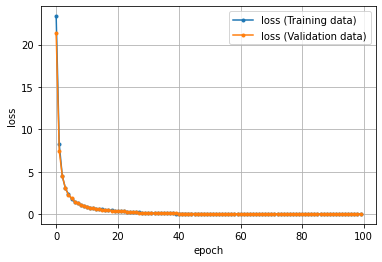

In [10]:
import matplotlib.pyplot as plt

# 学習結果（損失）のグラフを描画
epochs = len(train_history)
plt.plot(range(epochs), train_history, marker='.', label='loss (Training data)')
plt.plot(range(epochs), valid_history, marker='.', label='loss (Validation data)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

このコードのポイント：
- `train_history`と`valid_history`は、前述の「リスト7-4　「訓練」と「評価」をバッチサイズ単位でエポック回繰り返す」で記録しておいた損失の履歴である
- プロットする方法はいたって普通なので、特に本稿では説明しない